In [3]:
from utility import clean_data, plot_training_history

import pandas as pd
import numpy as np
from time import time
from keras import backend as K
from matplotlib import pyplot as plt

#import tensorflow as tf
import keras
import random
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


#from keras.callbacks import TensorBoard
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [4]:
name = ['transverse','longitudinal', 'crocodile','normal']

train_data = clean_data(r'train2.csv')
test_data = clean_data(r'test.csv',False)
train = train_data.feature.reshape((-1, 80, 80, 1))

train_x, test_x, train_onehot, test_onehot = train_test_split(train, train_data.onehot, test_size=0.2, random_state=42)


#调整权重w
class_weight = compute_class_weight(class_weight='balanced',
                             classes=np.unique(train_data.label),
                             y=train_data.label)

In [81]:
class Generator():
    def __init__(self, X, y, batch_size=32, aug=False):
        def generator():
            idg = ImageDataGenerator(horizontal_flip=True,
                                     rotation_range=20,
                                     zoom_range=0.2,
                                    )
            while True:
                index = [i for i in range(0, len(X), batch_size)]
                random.shuffle(index)
                for i in index:
                    X_batch = X[i:i+batch_size].copy()
                    y_batch = y[i:i+batch_size].copy() # [x[i:i+batch_size] for x in y]
                    if aug:
                        for j in range(len(X_batch)):
                            X_batch[j] = idg.random_transform(X_batch[j])
                    yield X_batch, y_batch
        self.generator = generator()
        self.steps = len(X) // batch_size + 1
        
gen_train = Generator(train_x, train_onehot, batch_size=64, aug=True)

In [82]:
# CNN模型
inputs = Input(shape=(80,80,1))

#第一层卷积
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(inputs)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.25)(net)

#第二层卷积
net = Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.25)(net)

#第三层卷积
net = Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
             activation='relu', name='layer_conv3')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = BatchNormalization(axis = -1)(net)
net = Dropout(0.5)(net)


# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# 第一个全连接层 / dense layer with ReLU-activation.
net = Dense(64)(net)
net = BatchNormalization(axis = -1)(net)
net = Activation('relu')(net)

# 最后一个全连接层 / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(4)(net)
net = BatchNormalization(axis = -1)(net)
net = Activation('softmax')(net)
# Output of the Neural Network.

outputs = net


In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 80, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 80, 80, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 40, 40, 16)        64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 40, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 40, 40, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)        0         
__________

Epoch 1/50
27/27 [==============================] - 39s 1s/step - loss: 1.2624 - acc: 0.4160 - val_loss: 1.0924 - val_acc: 0.4929

Epoch 00001: val_acc improved from -inf to 0.49292, saving model to epoch-01_loss-1.2641_val_acc-0.4929.h5
Epoch 2/50
27/27 [==============================] - 33s 1s/step - loss: 1.0658 - acc: 0.5353 - val_loss: 1.0691 - val_acc: 0.5165

Epoch 00002: val_acc improved from 0.49292 to 0.51651, saving model to epoch-02_loss-1.0634_val_acc-0.5165.h5
Epoch 3/50
27/27 [==============================] - 33s 1s/step - loss: 0.9918 - acc: 0.5788 - val_loss: 1.0737 - val_acc: 0.5118

Epoch 00003: val_acc did not improve from 0.51651
Epoch 4/50
27/27 [==============================] - 32s 1s/step - loss: 0.9288 - acc: 0.6309 - val_loss: 0.9800 - val_acc: 0.5590

Epoch 00004: val_acc improved from 0.51651 to 0.55896, saving model to epoch-04_loss-0.9264_val_acc-0.5590.h5
Epoch 5/50
27/27 [==============================] - 32s 1s/step - loss: 0.8848 - acc: 0.6541 - val_

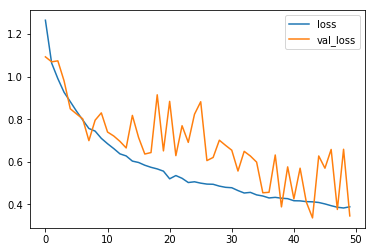

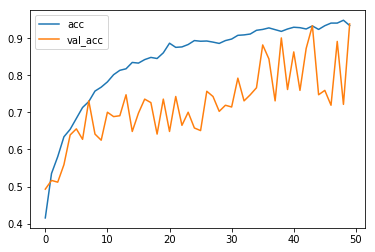

In [85]:
# 有数据增强
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(filepath='epoch-{epoch:02d}_loss-{loss:.4f}_val_acc-{val_acc:.4f}.h5',
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
y = model.fit_generator(gen_train.generator, 
                        steps_per_epoch=gen_train.steps, 
                        epochs=50,
                        callbacks=[model_checkpoint],
                        class_weight=class_weight,
                        validation_data=(test_x,test_onehot),
                        verbose=1)
plot_training_history(y)

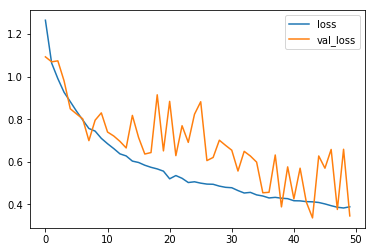

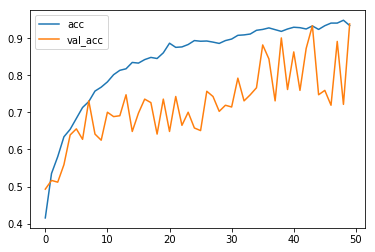

In [86]:
def plot_result_acc(r):
    
    #绘制折线图 accuracies
    plt.plot(r['acc'], label='acc')
    plt.plot(r['val_acc'], label='val_acc')
    plt.legend()
    plt.savefig("dnn_acc.png")
    plt.show()
    
def plot_result_loss(r):
    #绘制折线图 loss
    plt.plot(r['loss'],label='loss')
    plt.plot(r['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig("dnn_loss.png")
    plt.show()
dst = y.history
plot_result_loss(dst)   
plot_result_acc(dst)

In [97]:
model = keras.models.load_model('epoch-380_loss-0.0345_val_acc-0.9858.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


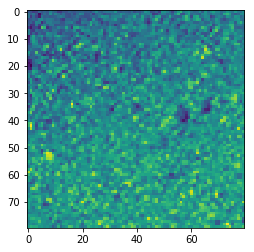

In [42]:
from keras.preprocessing import image 
import numpy as np

img_path = r'CNN-images/trainImages/4_50.png'
 
img = image.load_img(img_path,grayscale=True)
 
x = image.img_to_array(img)
 
x = np.expand_dims(x, axis=0)
 
plt.imshow(x.reshape((80,80)))
plt.show()

In [43]:
model = keras.models.load_model('epoch-380_loss-0.0345_val_acc-0.9858.h5')
preds = model.predict(x)

In [44]:
index = np.argmax(preds[0])
index

1

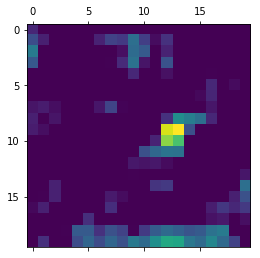

In [45]:
african_elephant_output = model.output[:, index]
last_conv_layer = model.get_layer('layer_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] 
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
if np.sum(np.maximum(heatmap, 0)) == 0:
    heatmap = np.minimum(heatmap, 0)
    heatmap /= np.min(heatmap)
else:
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

plt.matshow(heatmap)
plt.show()

In [49]:
import cv2
 
img = cv2.imread(r'CNN-images/trainImages/4_50.png')
img = img.reshape((80,80,-1))

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
 
heatmap = np.uint8(255 * heatmap)
 
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
 
superimposed_img = heatmap * 0.4 + img
superimposed_img
cv2.imwrite('4_cam.jpg', superimposed_img)

True

In [47]:
pimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
pimg = pimg.reshape((80,80,-1))

# pimg = np.expand_dims(pimg, axis=0)
print(pimg.shape)

(80, 80, 1)


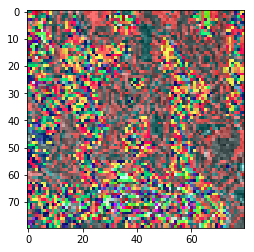

In [41]:
plt.imshow(superimposed_img)
plt.show()